In [1]:
#############################################
# Install necessary Python packages in the notebook environment, if importing in next cell throws error.
# Uncomment the next line to run installation if required.


# !pip install -q pandas numpy seaborn matplotlib scikit-learn xgboost

#############################################

In [2]:
# Load necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score

/Users/anshita.aishwarya/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/anshita.aishwarya/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


# Data Understanding and EDA

In [3]:
# Load the dataset
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 7043 rows and 21 columns


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
# Separate numerical and categorical columns
num_cols = df.select_dtypes(include=['number']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumber of numerical columns: {len(num_cols)}")
print("Numerical Columns:", num_cols)

print(f"\nNumber of Categorical Columns: {len(cat_cols)}")
print("Categorical Columns:", cat_cols)


Number of numerical columns: 3
Numerical Columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges']

Number of Categorical Columns: 18
Categorical Columns: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'Churn']


Looking at the data, we can see that the column `TotalCharges` is a numerical field but stored as object. Thus, we need to convert them to float.

In [7]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop rows that couldn't be converted to numeric
df = df.dropna(subset=['TotalCharges'])
df.reset_index(drop=True, inplace=True)

In [8]:
# Summary statistics for numerical & categorical columns
num_cols = df.select_dtypes(include=['number']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

if num_cols:
    print("\nSummary Statistics (Numerical Features):")
    display(df[num_cols].describe())

if cat_cols:
    print("\nSummary Statistics (Categorical Features):")
    display(df[cat_cols].describe(include='object'))


Summary Statistics (Numerical Features):


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000



Summary Statistics (Categorical Features):


,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032
unique,7032,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,7590-VHVEG,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,1,3549,3639,4933,6352,3385,3096,3497,3087,3094,3472,2809,2781,3875,4168,2365,5163


In [9]:
# Unique value per categorical column
if cat_cols:
    print("\nUnique Values per Categorical Column:")
    for col in cat_cols:
        unique_vals = df[col].unique()
        num_unique = df[col].nunique()
        print(f"• {col}: {num_unique} unique values -> {unique_vals[:10]}{'...' if num_unique > 10 else ''}")


Unique Values per Categorical Column:
• customerID: 7032 unique values -> ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' '7795-CFOCW' '9237-HQITU'
 '9305-CDSKC' '1452-KIOVK' '6713-OKOMC' '7892-POOKP' '6388-TABGU']...
• gender: 2 unique values -> ['Female' 'Male']
• Partner: 2 unique values -> ['Yes' 'No']
• Dependents: 2 unique values -> ['No' 'Yes']
• PhoneService: 2 unique values -> ['No' 'Yes']
• MultipleLines: 3 unique values -> ['No phone service' 'No' 'Yes']
• InternetService: 3 unique values -> ['DSL' 'Fiber optic' 'No']
• OnlineSecurity: 3 unique values -> ['No' 'Yes' 'No internet service']
• OnlineBackup: 3 unique values -> ['Yes' 'No' 'No internet service']
• DeviceProtection: 3 unique values -> ['No' 'Yes' 'No internet service']
• TechSupport: 3 unique values -> ['No' 'Yes' 'No internet service']
• StreamingTV: 3 unique values -> ['No' 'Yes' 'No internet service']
• StreamingMovies: 3 unique values -> ['No' 'Yes' 'No internet service']
• Contract: 3 unique values -> ['Month-to-mon

In [10]:
# Handle missing data
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

The dataset doesn't have any missing values. <br><br>
Let's perform some EDA to understand the data distributions.

### Target Variable Distribution (`Churn` : Yes, No)

In [11]:
# Target variable distribution
print("\nTarget Variable ('Churn') Distribution:")
print(df['Churn'].value_counts(normalize=True).map("{:.2%}".format))


Target Variable ('Churn') Distribution:
Churn
No     73.42%
Yes    26.58%
Name: proportion, dtype: object


With approximately 73.5% of samples labeled as 'No' and 26.5% labeled as 'Yes', we identify this is a moderately imbalanced dataset.

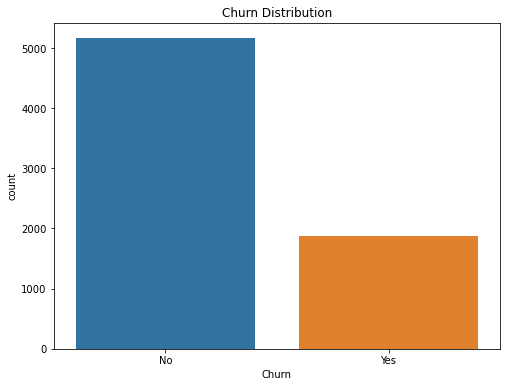

In [12]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Churn', hue='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

### Customer Churn by Gender

In [13]:
df[['Churn', 'gender']].value_counts().unstack()

gender,Female,Male
Churn,,
No,2544,2619
Yes,939,930


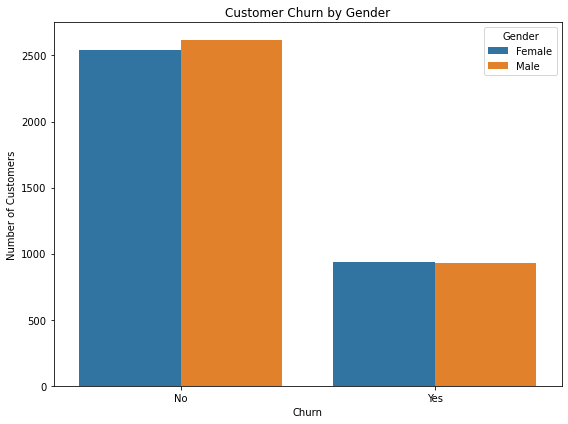

In [14]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Churn', hue='gender', data=df)
plt.title("Customer Churn by Gender")
plt.xlabel('Churn')
plt.ylabel('Number of Customers')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

We can see that the churn rate is fairly similar between genders. Therefore, gender alone may not be a strong predictor of churn.

### Churn Rate by Contract Length

In [15]:
df[['Contract', 'gender']].value_counts().unstack()

gender,Female,Male
Contract,,
Month-to-month,1925,1950
One year,718,754
Two year,840,845


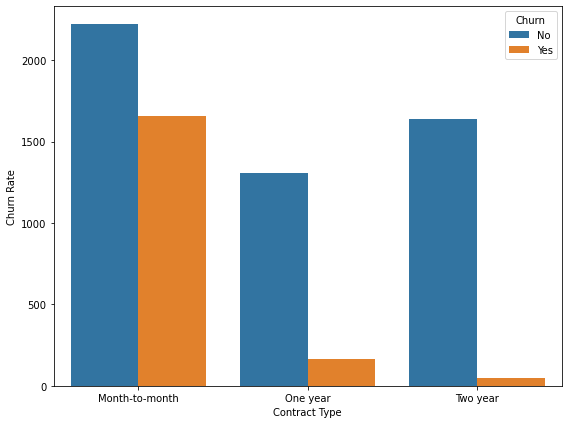

In [16]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Contract',hue='Churn', data=df)
plt.ylabel('Churn Rate')
plt.xlabel('Contract Type')
plt.legend(title='Churn')
plt.tight_layout()
plt.show()

Customers with month-to-month contracts have much higher churn rates. Longer-term contracts (1 or 2 years) have a considerably lesser churn rate. This suggests that contract Length inversely correlates with churn and could be a strong retention factor.

### Tenure vs Churn

In [17]:
df[['tenure', 'Churn']].value_counts().unstack().head(5)

Churn,No,Yes
tenure,,
1,233,380
2,115,123
3,106,94
4,93,83
5,69,64


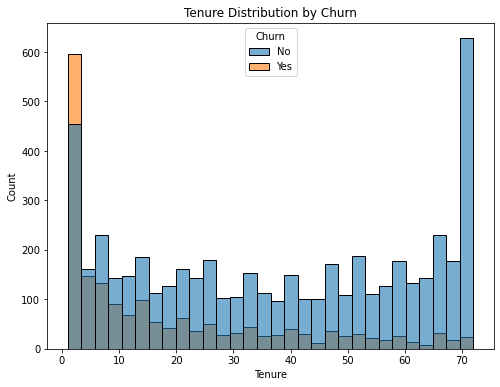

In [18]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='tenure', hue='Churn', bins=30, alpha=0.6)
plt.title('Tenure Distribution by Churn')
plt.xlabel('Tenure')
plt.ylabel('Count')
plt.show()

Churning customers tend to have much shorter tenures. The highest churn risk occurs within the first 12 months of customer tenure, with churn dramatically decreasing after this initial period.  Those who stay beyond the first 12 months are less likely to churn.

### Monthly Charges and Total Charges vs Churn

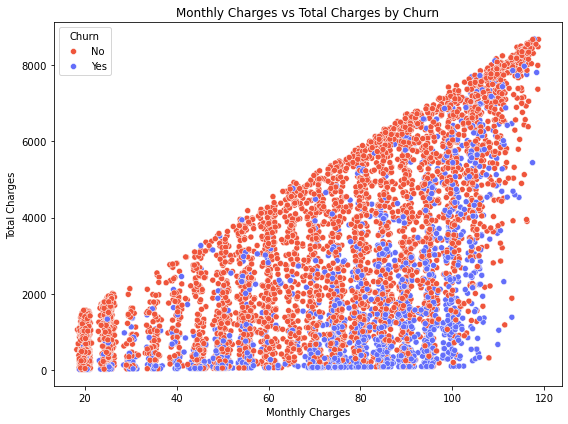

In [19]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x='MonthlyCharges',
    y='TotalCharges',
    hue='Churn',
    palette=['#EF553B', '#636EFA']
)

plt.title('Monthly Charges vs Total Charges by Churn')
plt.xlabel('Monthly Charges')
plt.ylabel('Total Charges')
plt.legend(title='Churn')
plt.tight_layout()
plt.show()

We can observe that customers who pay higher monthly charges tend to churn. It may be due to expensive plans that cause customers to churn. As per the graph, `$20 - $60` may be the optimal pricing zone for customer retention, as it shows better retention patterns with fewer red dots as compared to blue ones.

### Payment Method vs Churn

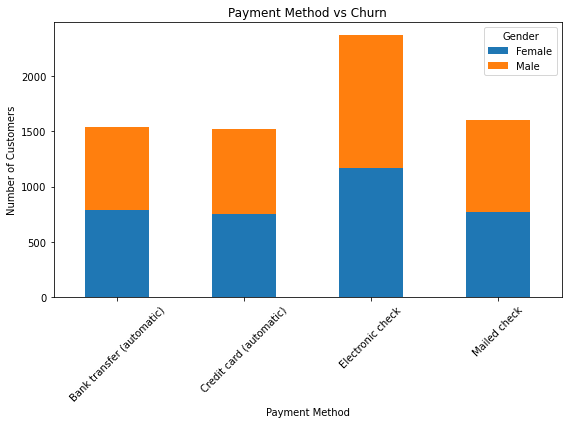

In [20]:
pd.crosstab(df['PaymentMethod'], df['gender']).plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title('Payment Method vs Churn')
plt.xlabel('Payment Method')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

Electronic check payment method has the highest churn rate regardless of gender. Customers with automatic payments (credit card, bank transfer) show lower churn, suggesting that payment convenience encourages customer retention.

### Correlation of numerical features

In [21]:
df_corr = df[num_cols].corr()
print(df_corr)

                SeniorCitizen    tenure  MonthlyCharges  TotalCharges
SeniorCitizen        1.000000  0.015683        0.219874      0.102411
tenure               0.015683  1.000000        0.246862      0.825880
MonthlyCharges       0.219874  0.246862        1.000000      0.651065
TotalCharges         0.102411  0.825880        0.651065      1.000000


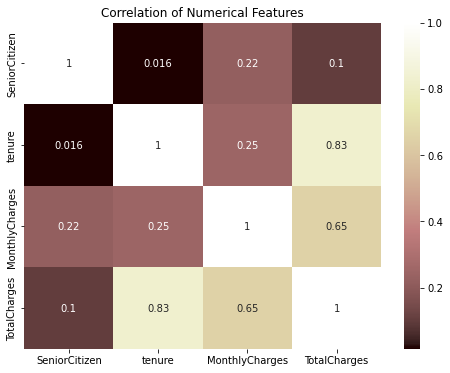

In [22]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_corr, annot=True, cmap='pink')
plt.title('Correlation of Numerical Features')
plt.show()

# Data Processing and Feature Engineering

### Feature Engineering

In [23]:
# Feature Engineering

# Number of services used by the customer
services = ['PhoneService', 'MultipleLines', 'OnlineSecurity',
                'OnlineBackup', 'DeviceProtection', 'TechSupport',
                'StreamingTV', 'StreamingMovies']
df['NumServices'] = df[services].apply(lambda x: sum(x == 'Yes'), axis=1)

# Flag for high monthly charges (> $80 threshold)
df['HighMonthlyCharges'] = df['MonthlyCharges'].apply(lambda x: 1 if x > 80 else 0)

# Combines senior citizen status and dependents
df['IsSeniorDependent'] = df.apply(lambda x: 'Yes' if x['SeniorCitizen'] == 'Yes'
                                   and x['Dependents'] == 'Yes' else 'No', axis=1)

# Cost per service used
df['PricePerService'] = df['MonthlyCharges'] / (df['NumServices'] + 1)

In [24]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,NumServices,HighMonthlyCharges,IsSeniorDependent,PricePerService
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,Month-to-month,Yes,Electronic check,29.85,29.85,No,1,0,No,14.9250
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,One year,No,Mailed check,56.95,1889.50,No,3,0,No,14.2375
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,3,0,No,13.4625
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,One year,No,Bank transfer (automatic),42.30,1840.75,No,3,0,No,10.5750
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,0,No,35.3500


### Feature Selection

**Features to Keep:**<br>
The below features have shown strong correlation with `Churn` or have strong business relevance.<br>
1. ***tenure:*** customers with longer tenure have more retention
2. ***Contract:*** long term contract reduce churn
3. ***OnlineSecurity:*** digital safety supports customer retention
4. ***TechSupport:*** tech support leads to better engagement
5. ***Monthly Charges:*** higher charges lead to higher customer churn
6. ***PaperlessBilling:*** slight correlation with churn
7. ***Internet Service:*** types of service impacts churn
8. ***Payment Method:*** certain payment types correlate to churn
9. ***Senior Citizen:*** indicator of demographic

**Features to Drop:**<br>
The below features are either weakly correlated with `Churn`, redundant or irrelevant.<br>
1. ***customerID:*** identifier for each customer
2. ***TotalCharges:*** highly correlated with MonthlyCharges
3. ***gender:*** no meaningful impact
4. ***Partner, Dependents:*** weak correlation
5. ***PhoneService, MultipleLines:*** low impact
6. ***StreamingTV, StreamingMovies:*** low impact
7. ***DeviceProtection, OnlineBackup:*** low impact

In [25]:
selected_cat_cols = [
    'gender', 'SeniorCitizen','InternetService', 'OnlineSecurity',
    'TechSupport', 'Contract', 'PaperlessBilling',
    'PaymentMethod', 'IsSeniorDependent'
]

selected_num_cols = [
    'tenure', 'MonthlyCharges',
    'NumServices', 'HighMonthlyCharges', 'PricePerService'
]

selected_features = selected_cat_cols + selected_num_cols

# Define X and y
X = df[selected_features].copy()
y = df['Churn'].map({'Yes': 1, 'No': 0})

print("X shape", X.shape)
print("y shape", y.shape)

X shape (7032, 14)
y shape (7032,)


### Data Processing

The first step is to split the dataset into train and test sets, and later perform any transformations (such as scaling, encoding etc.) to avoid data leakage.

In [26]:
# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)
print("y_train shape", y_train.shape)
print("y_test shape", y_test.shape)

X_train shape (5625, 14)
X_test shape (1407, 14)
y_train shape (5625,)
y_test shape (1407,)


In [27]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), selected_num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), selected_cat_cols)
    ],
    remainder='drop'
)

# Model Building

### Model Training


Model LogisticRegression trained successfully.

Classification Report for LogisticRegression:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.63      0.52      0.57       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407

LogisticRegression — Accuracy: 0.79, ROC AUC: 0.828
Confusion Matrix:


array([[919, 114],
       [181, 193]])


Model RandomForest trained successfully.

Classification Report for RandomForest:
              precision    recall  f1-score   support

           0       0.82      0.87      0.85      1033
           1       0.57      0.48      0.52       374

    accuracy                           0.77      1407
   macro avg       0.70      0.68      0.69      1407
weighted avg       0.76      0.77      0.76      1407

RandomForest — Accuracy: 0.767, ROC AUC: 0.808
Confusion Matrix:


array([[898, 135],
       [193, 181]])


Model XGBoost trained successfully.

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1033
           1       0.58      0.49      0.53       374

    accuracy                           0.77      1407
   macro avg       0.70      0.68      0.69      1407
weighted avg       0.76      0.77      0.76      1407

XGBoost — Accuracy: 0.769, ROC AUC: 0.805
Confusion Matrix:


/Users/anshita.aishwarya/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:43:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


array([[897, 136],
       [189, 185]])

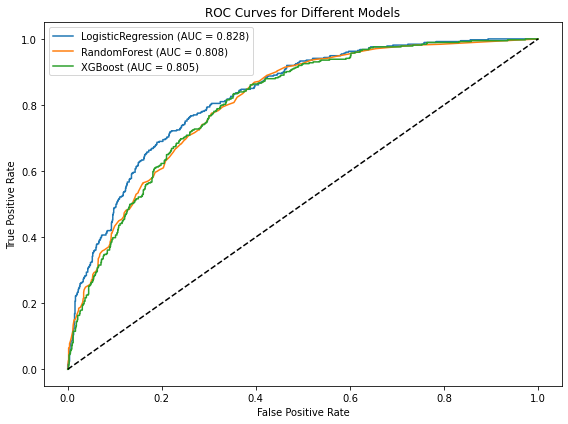

In [28]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}
metrics = {}

# Train & Evaluate Models

plt.figure(figsize=(8, 6))

for name, clf in models.items():
    # Build pipeline for each model
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])

    # Fit on training data
    model.fit(X_train, y_train)
    print(f"\nModel {name} trained successfully.")

    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Evaluation
    print(f"\nClassification Report for {name}:\n{classification_report(y_test, y_pred)}")
    acc = round(accuracy_score(y_test, y_pred), 3)
    auc = round(roc_auc_score(y_test, y_prob), 3)

    print(f"{name} — Accuracy: {acc}, ROC AUC: {auc}")
    print("Confusion Matrix:")
    display(confusion_matrix(y_test, y_pred))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc})")

    # Store results
    results[name] = {
        "pipeline": model,
        "auc": auc,
        "acc": acc
    }
    metrics[name] = {
        "accuracy": acc,
        "roc_auc": auc,
        "classification_report": classification_report(y_test, y_pred, output_dict=True),
        "confusion_matrix": confusion_matrix(y_test, y_pred).tolist()
    }

# Plot ROC Curve
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend()
plt.tight_layout()
plt.show()

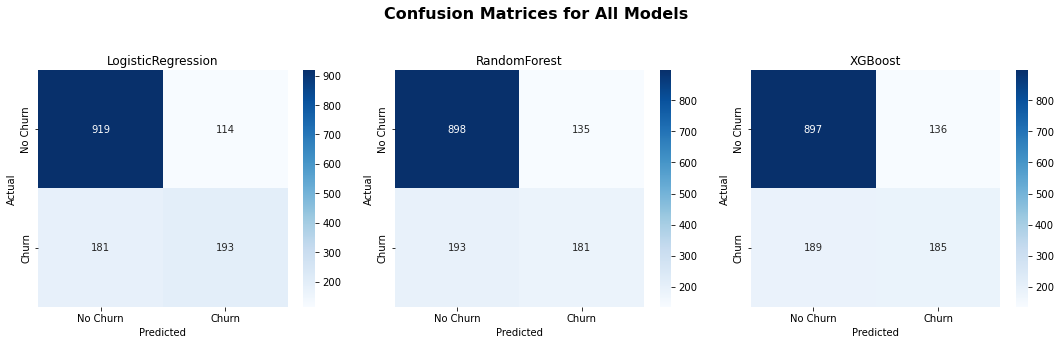

In [29]:
model_names = ["LogisticRegression", "RandomForest", "XGBoost"]
labels = ["No Churn", "Churn"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, name in enumerate(model_names):
    cm = np.array(metrics[name]["confusion_matrix"])
    ax = axes[i]
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
                xticklabels=labels, yticklabels=labels)
    ax.set_title(f"{name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.suptitle("Confusion Matrices for All Models", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Model Evaluation

In [30]:
best_model_name = max(results, key=lambda name: results[name]['auc'])
print(f"\n Best model: {best_model_name} with AUC: {results[best_model_name]['auc']}")
best_model = results[best_model_name]['pipeline']


 Best model: LogisticRegression with AUC: 0.828


**Logistic Regression** has been identified as the best performing model with AUC of 0.828

# Model Fine Tuning

### Hyperparameter Tuning

In [31]:
# Fine tuning the model with GridSearchCV
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear')) # liblinear is good for small datasets or L1 penalty
])

# Define hyperparameter grid for fine-tuning
param_grid = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.01, 0.1, 1, 10, 100]
}

# Grid search
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

# Fit
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
print("Best hyperparameters:", grid_search.best_params_)
print("Best ROC AUC score:", grid_search.best_score_)

# Evaluate on test set
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nTest ROC AUC:", roc_auc_score(y_test, y_proba))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/anshita.aishwarya/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/anshita.aishwarya/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/anshita.aishwarya/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/anshita.aishwarya/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of

Best hyperparameters: {'classifier__C': 10, 'classifier__penalty': 'l2'}
Best ROC AUC score: 0.8434774510677239

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.63      0.52      0.57       374

    accuracy                           0.79      1407
   macro avg       0.74      0.70      0.72      1407
weighted avg       0.78      0.79      0.79      1407


Confusion Matrix:
[[922 111]
 [181 193]]

Test ROC AUC: 0.8277394122306142


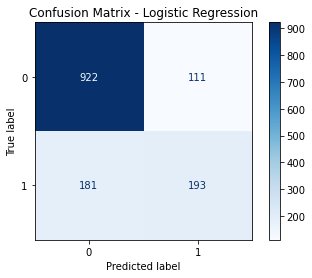

In [32]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

### Feature Importance

                            Feature  Coefficient  Abs_Coefficient
2                       NumServices     2.719931         2.719931
0                            tenure    -2.436363         2.436363
1                    MonthlyCharges    -2.097568         2.097568
20                Contract_Two year    -0.730606         0.730606
10      InternetService_Fiber optic     0.624312         0.624312
18          Contract_Month-to-month     0.614660         0.614660
9               InternetService_DSL    -0.544349         0.544349
4                   PricePerService     0.511599         0.511599
12                OnlineSecurity_No     0.360465         0.360465
16  TechSupport_No internet service    -0.359330         0.359330


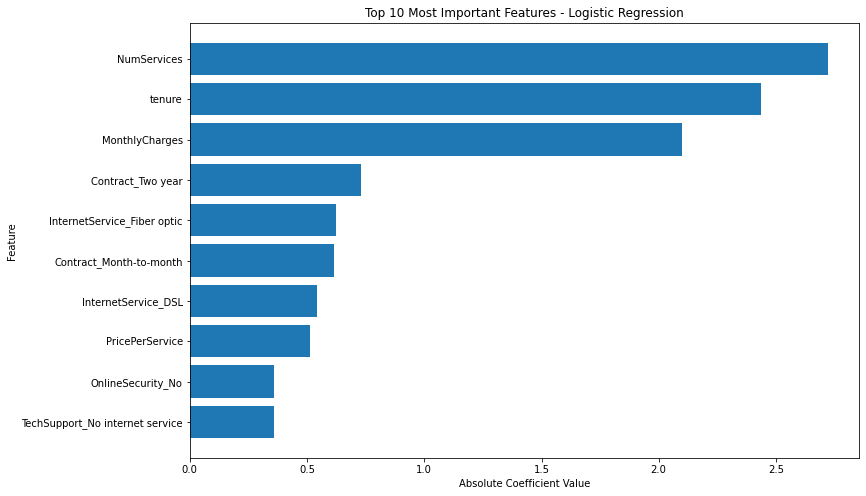

In [33]:
# Get the fitted logistic regression model from the pipeline
final_model = grid_search.best_estimator_

# Get the feature names after preprocessing
# Numeric features
num_features = selected_num_cols

# Categorical features (after one-hot encoding)
cat_features = final_model.named_steps['preprocessor'] \
    .named_transformers_['cat'] \
    .get_feature_names_out(selected_cat_cols)

# Combine numeric + categorical
all_features = np.concatenate([num_features, cat_features])

# Get coefficients from Logistic Regression
log_reg = final_model.named_steps['classifier']  # logistic regression model
coefficients = log_reg.coef_[0]  # for binary classification

# Create DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
})

# Sort by absolute coefficient value
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

# Display top features
print(feature_importance.head(10))

# Plot
plt.figure(figsize=(12, 8))
plt.barh(feature_importance['Feature'][:10], feature_importance['Abs_Coefficient'][:10])
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Feature")
plt.title("Top 10 Most Important Features - Logistic Regression")
plt.gca().invert_yaxis()
plt.show()

The most influential features identified by the model are: **NumServices**, **tenure**, **MonthlyCharges** and **Contract_Two year**.